In [1]:
import numpy as np
import pandas as pd
import torch
from torch.nn import Linear, LayerNorm, ReLU, Dropout
import torch.nn.functional as F
from torch_geometric.nn import ChebConv, NNConv, DeepGCNLayer, GATConv, DenseGCNConv, GCNConv, GraphConv
from torch_geometric.data import Data, DataLoader

from sklearn.metrics import roc_auc_score
import scipy.sparse as sp

import warnings
warnings.filterwarnings("ignore")

import torch
import torch.nn as nn
from torch.autograd import Variable
from torch.nn.parameter import Parameter
from collections import OrderedDict
import numpy as np
import torch.nn.functional as F


In [2]:
import pandas as pd
df_features = pd.read_csv('elliptic_bitcoin_dataset/elliptic_txs_features.csv', header=None)
df_edges = pd.read_csv("elliptic_bitcoin_dataset/elliptic_txs_edgelist.csv")
df_classes =  pd.read_csv("elliptic_bitcoin_dataset/elliptic_txs_classes.csv")
df_classes['class'] = df_classes['class'].map({'unknown': 2, '1':1, '2':0})

In [3]:
# merging dataframes
df_merge = df_features.merge(df_classes, how='left', right_on="txId", left_on=0)
df_merge = df_merge.sort_values(0).reset_index(drop=True)
classified = df_merge.loc[df_merge['class'].loc[df_merge['class']!=2].index].drop('txId', axis=1)
unclassified = df_merge.loc[df_merge['class'].loc[df_merge['class']==2].index].drop('txId', axis=1)

# storing classified unclassified nodes seperatly for training and testing purpose
classified_edges = df_edges.loc[df_edges['txId1'].isin(classified[0]) & df_edges['txId2'].isin(classified[0])]
unclassifed_edges = df_edges.loc[df_edges['txId1'].isin(unclassified[0]) | df_edges['txId2'].isin(unclassified[0])]
del df_features, df_classes

In [4]:
# all nodes in data
nodes = df_merge[0].values
map_id = {j:i for i,j in enumerate(nodes)} # mapping nodes to indexes

edges = df_edges.copy()
edges.txId1 = edges.txId1.map(map_id)
edges.txId2 = edges.txId2.map(map_id)
edges = edges.astype(int)

edge_index = np.array(edges.values).T

# for undirected graph
# edge_index_ = np.array([edge_index[1,:], edge_index[0, :]])
# edge_index = np.concatenate((edge_index, edge_index_), axis=1)

edge_index = torch.tensor(edge_index, dtype=torch.long).contiguous()
weights = torch.tensor([1]* edge_index.shape[1] , dtype=torch.double)
print(edge_index.shape)

torch.Size([2, 234355])


In [5]:
# maping txIds to corresponding indexes, to pass node features to the model
node_features = df_merge.drop(['txId'], axis=1).copy()
node_features[0] = node_features[0].map(map_id)
classified_idx = node_features['class'].loc[node_features['class']!=2].index
unclassified_idx = node_features['class'].loc[node_features['class']==2].index
# replace unkown class with 0, to avoid having 3 classes, this data/labels never used in training
node_features['class'] = node_features['class'].replace(2, 0) 

In [6]:
labels = node_features['class'].values
node_features = torch.tensor(np.array(node_features.drop([0, 'class', 1], axis=1).values, dtype=np.double), dtype=torch.double)

# converting data to PyGeometric graph data format
data_train = Data(x=node_features, edge_index=edge_index, edge_attr=weights,
                               y=torch.tensor(labels, dtype=torch.double)) #, adj= torch.from_numpy(np.array(adj))

In [7]:
y_train = labels[classified_idx]

# spliting train set and validation set
from sklearn.model_selection import train_test_split
X_train, X_valid, y_train, y_valid, train_idx, valid_idx = train_test_split(node_features[classified_idx], y_train, classified_idx, test_size=0.15, random_state=42, stratify=y_train)

In [8]:
import gc
gc.collect()

21

In [90]:
import torch.nn.functional as F
from sklearn.metrics import roc_auc_score
class Net(torch.nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        
        self.conv1 = GCNConv(165, 64)
        self.conv2 = GCNConv(64, 32)
        self.conv3 = GCNConv(32, 32)
#         self.conv4 = GCNConv(64, 1) 

    def forward(self, data, adj=None):
        x, edge_index = data.x, data.edge_index
        
        x = self.conv1(x, edge_index)
        x = F.relu(x)
        x = F.dropout(x, p=0.1, training=self.training)
        
        x = self.conv2(x, edge_index)
        x = F.relu(x)
        x = F.dropout(x, p=0.1, training=self.training)
        
        x = self.conv3(x, edge_index)
        x = F.relu(x)
        x = F.dropout(x, p=0.1, training=self.training)
        
        return x
#         return F.sigmoid(x)

    def get_out_feature_size(self):
        return 32

In [91]:
class Tree(nn.Module):
    def __init__(self,depth,n_in_feature,used_feature_rate,n_class):
        super(Tree, self).__init__()
        self.depth = depth
        self.n_leaf = 2 ** depth
        self.n_class = n_class

        # used features in this tree
        n_used_feature = int(n_in_feature*used_feature_rate)
        onehot = np.eye(n_in_feature)
        using_idx = np.random.choice(np.arange(n_in_feature), n_used_feature, replace=False)
        self.feature_mask = onehot[using_idx].T
        self.feature_mask = Parameter(torch.from_numpy(self.feature_mask).type(torch.FloatTensor),requires_grad=False)

        # leaf label distribution
        self.pi = np.random.rand(self.n_leaf,n_class)
        self.pi = Parameter(torch.from_numpy(self.pi).type(torch.FloatTensor),requires_grad=True)
        
        # decision
        self.decision = nn.Sequential(OrderedDict([
                        ('linear1',nn.Linear(n_used_feature,self.n_leaf)),
                        ('sigmoid', nn.Sigmoid()),
                        ]))

    def forward(self,x):
        """
        :param x(Variable): [batch_size,n_features]
        :return: route probability (Variable): [batch_size,n_leaf]
        """
        if x.is_cuda and not self.feature_mask.is_cuda:
            self.feature_mask = self.feature_mask.cuda()

        feats = torch.mm(x,self.feature_mask) # ->[batch_size,n_used_feature]
        decision = self.decision(feats) # ->[batch_size,n_leaf]

        decision = torch.unsqueeze(decision,dim=2)
        decision_comp = 1-decision
        decision = torch.cat((decision,decision_comp),dim=2) # -> [batch_size,n_leaf,2]

        # compute route probability
        # note: we do not use decision[:,0]
        batch_size = x.size()[0]
        _mu = Variable(x.data.new(batch_size,1,1).fill_(1.))
        begin_idx = 1
        end_idx = 2
        for n_layer in range(0, self.depth):
            _mu = _mu.view(batch_size,-1,1).repeat(1,1,2)
            _decision = decision[:, begin_idx:end_idx, :]  # -> [batch_size,2**n_layer,2]
            _mu = _mu*_decision # -> [batch_size,2**n_layer,2]
            begin_idx = end_idx
            end_idx = begin_idx + 2 ** (n_layer+1)

        mu = _mu.view(batch_size,self.n_leaf)
        return mu

    def get_pi(self):
        return F.softmax(self.pi,dim=-1)

    def cal_prob(self,mu,pi):
        """
        :param mu [batch_size,n_leaf]
        :param pi [n_leaf,n_class]
        :return: label probability [batch_size,n_class]
        """
        p = torch.mm(mu,pi)
        return p


    def update_pi(self,new_pi):
        self.pi.data=new_pi


In [92]:
class Forest(nn.Module):
    def __init__(self,n_tree,tree_depth,n_in_feature,tree_feature_rate,n_class):
        super(Forest, self).__init__()
        self.trees = nn.ModuleList()
        self.n_tree  = n_tree
        for _ in range(n_tree):
            tree = Tree(tree_depth,n_in_feature,tree_feature_rate,n_class)
            self.trees.append(tree)

    def forward(self,x):
        probs = []
        for tree in self.trees:
            mu = tree(x)
            p=tree.cal_prob(mu,tree.get_pi())
            probs.append(p.unsqueeze(2))
        probs = torch.cat(probs,dim=2)
        prob = torch.sum(probs,dim=2)/self.n_tree
        return prob


In [93]:
class NeuralDecisionForest(nn.Module):
    def __init__(self, feature_layer, forest):
        super(NeuralDecisionForest, self).__init__()
        self.feature_layer = feature_layer
        self.forest = forest

    def forward(self, x):
        out = self.feature_layer(x) #GCN
        out = out.view(x.size()[0],-1)
        out = self.forest(out) # Random Forest
        return out

epoch: 0 - loss: 0.5682557026576809 - roc: 0.714022727167962
epoch: 50 - loss: 0.3242539333781292 - roc: 0.8177400883670346
epoch: 100 - loss: 0.23359513681481436 - roc: 0.8435507614402307
epoch: 150 - loss: 0.1879214887363593 - roc: 0.843969045271486
epoch: 200 - loss: 0.16175664994550873 - roc: 0.8473545886934365
epoch: 250 - loss: 0.15069019626141344 - roc: 0.8483342372436948
epoch: 300 - loss: 0.14427957750215556 - roc: 0.8491972053992715
epoch: 350 - loss: 0.14040425243248159 - roc: 0.8495394695815149
epoch: 400 - loss: 0.13724377919136818 - roc: 0.8500263403354568
epoch: 450 - loss: 0.1351510471720643 - roc: 0.851336109203543
epoch: 500 - loss: 0.1336285437289799 - roc: 0.8502115424216822
epoch: 550 - loss: 0.13355970499485717 - roc: 0.8512364831287477
epoch: 600 - loss: 0.13128390292871145 - roc: 0.8524683261488719
epoch: 650 - loss: 0.1322068309609429 - roc: 0.8542007167192085
epoch: 700 - loss: 0.12919806894413524 - roc: 0.8549801636443531
epoch: 750 - loss: 0.1293212832342618

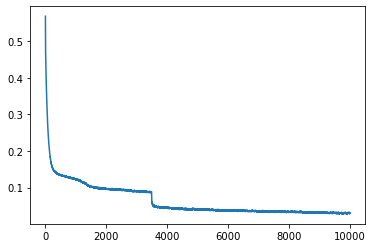

In [222]:
import matplotlib.pyplot as plt

# hyper-parameters
batch_size = 32
feat_dropout = 0.5
n_tree = 3
tree_depth = 1
tree_feature_rate = 0.5
lr = 0.001
epochs = 10001
report_every = 10

n_class = 2

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

feat_layer = Net()
forest = Forest(n_tree=n_tree,tree_depth=tree_depth,n_in_feature=feat_layer.get_out_feature_size(),
                        tree_feature_rate=tree_feature_rate,n_class=n_class)
model = NeuralDecisionForest(feat_layer,forest)
    
# model = Net().to(device)
model = model.to(device)
model.double()

data_train = data_train.to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=0.01, weight_decay=1e-5)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, 'min')
criterion = torch.nn.BCELoss()

loss_vals= []
model.train()
for epoch in range(epochs):
    optimizer.zero_grad()
    out = model(data_train)
    # data_train.y.unsqueeze(1)
#     out = out.reshape((data_train.x.shape[0]))
    out = out[:, 0]
    loss = criterion(out[train_idx], data_train.y[train_idx])
    auc = roc_auc_score(data_train.y.detach().cpu().numpy()[train_idx], out.detach().cpu().numpy()[train_idx]) #[train_idx]
    loss.backward()
    loss_vals.append(loss.item())
    optimizer.step()
    if epoch%50 == 0:
      print("epoch: {} - loss: {} - roc: {}".format(epoch, loss.item(), auc))
    
plt.plot(np.linspace(1, epochs, epochs).astype(int), loss_vals)

In [223]:
preds = model(data_train)
preds = preds.detach().cpu().numpy()
preds = preds[:, 0]

In [224]:
from sklearn.metrics import accuracy_score
out_labels = preds > 0.5
train_acc = accuracy_score(data_train.y.detach().cpu().numpy()[train_idx], out_labels[train_idx])
train_auc = roc_auc_score(data_train.y.detach().cpu().numpy()[train_idx], preds[train_idx])
print("train accuracy: ", train_acc)
print("train AUC: ", train_auc)

train accuracy:  0.9932287324086005
train AUC:  0.9848535207146714


In [225]:
valid_auc = roc_auc_score(data_train.y.detach().cpu().numpy()[valid_idx], preds[valid_idx])
out_labels = out.detach().cpu().numpy() > 0.5
valid_acc = accuracy_score(data_train.y.detach().cpu().numpy()[valid_idx], out_labels[valid_idx])
print("valid accuracy: ", valid_acc)
print("valid AUC: ", valid_auc)

valid accuracy:  0.9676449534717251
valid AUC:  0.9564943240266819


In [226]:
from sklearn.metrics import roc_curve, confusion_matrix
# confusion matrix for validation data
cm = confusion_matrix(data_train.y.detach().cpu().numpy()[valid_idx], out_labels[valid_idx])
cm

array([[6234,   69],
       [ 157,  525]])

In [234]:
# 6234/(6234+69)
525/(157+525)

0.7697947214076246

In [227]:
# confusion matrix for train data
cm = confusion_matrix(data_train.y.detach().cpu().numpy()[train_idx], out_labels[train_idx])
cm

array([[35642,    74],
       [  199,  3664]])

In [228]:
from sklearn.metrics import f1_score, classification_report

f1_score(data_train.y.detach().cpu().numpy()[valid_idx], out_labels[valid_idx])

0.8228840125391849

In [229]:
print(classification_report(data_train.y.detach().cpu().numpy()[valid_idx], out_labels[valid_idx]))

              precision    recall  f1-score   support

         0.0       0.98      0.99      0.98      6303
         1.0       0.88      0.77      0.82       682

    accuracy                           0.97      6985
   macro avg       0.93      0.88      0.90      6985
weighted avg       0.97      0.97      0.97      6985



In [231]:
f1_score(data_train.y.detach().cpu().numpy()[train_idx], out_labels[train_idx])

0.9640836732008946

In [232]:
print(classification_report(data_train.y.detach().cpu().numpy()[train_idx], out_labels[train_idx]))

              precision    recall  f1-score   support

         0.0       0.99      1.00      1.00     35716
         1.0       0.98      0.95      0.96      3863

    accuracy                           0.99     39579
   macro avg       0.99      0.97      0.98     39579
weighted avg       0.99      0.99      0.99     39579



Text(0, 0.5, 'loss')

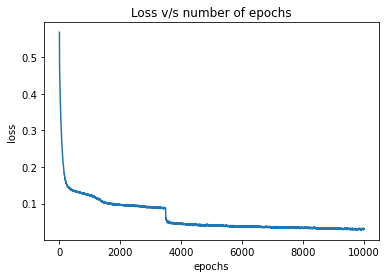

In [235]:
plt.plot(np.linspace(1, epochs, epochs).astype(int), loss_vals)
plt.title("Loss v/s number of epochs")
plt.xlabel("epochs")
plt.ylabel("loss")

Text(0, 0.5, 'loss')

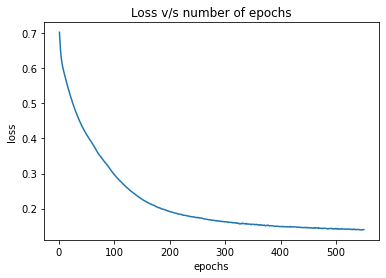

In [211]:
plt.plot(np.linspace(1, epochs, epochs).astype(int), loss_vals)
plt.title("Loss v/s number of epochs")
plt.xlabel("epochs")
plt.ylabel("loss")